In [124]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.spatial.distance import cdist
import re
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt

## 1. Kickoff
Upon gaining some intuition on the impact of the raw features - after the initial iteration through AutoML - we spent a day brainstorming what other features can be relevant to the problem. The process started with the individual team members listing up what we intuitively think matter for predicting the revenue to stores. The process yielded a short list of prospective features that we in turn split up in the feature engineering stage.

### 1.1. Feature brainstorming
The initial hypothesis was that features that were intrinsic to the store should have the greatest impact. Intuitively, since the problem statement is related to the prediction of revenue, we knew that certain types of store generated high traffic of sales - such as grocery stores and restaurants.

Secondly, as income levels and foot traffic vary throughout the country we also expected that the location of the store will have significant impact in predicting revenue. For example, we would expect stores that are more centrally located within a region to yield higher revenue compared to stores that are located in the suburbs. While there are certain stores that are high-traffic due to them being frequented by commuters traveling from point A to point B, we still believe that clustering surrounding city centers to be generally positively correlated with revenue.

In [33]:
def raw_read(path, file_name, dtype=None):
    """
        Utility function to simplify reading of files from local machine.
    """
    return pd.read_csv(f"{path}{file_name}.csv", dtype=dtype)

In [69]:
raw_path = "/Users/nwong/Workspace/Projects/tdt4173_project/data/raw/"

raw_stores_train = raw_read(raw_path, "stores_train", {'grunnkrets_id':str})
raw_stores_test = raw_read(raw_path, "stores_test", {'grunnkrets_id':str})
raw_stores_extra = raw_read(raw_path,"stores_extra", {'grunnkrets_id':str})

raw_income_dist = raw_read(raw_path, "grunnkrets_income_households", {'grunnkrets_id':str})
raw_age_dist = raw_read(raw_path, "grunnkrets_age_distribution", {'grunnkrets_id':str})
raw_households_dist = raw_read(raw_path, "grunnkrets_households_num_persons", {'grunnkrets_id':str})
raw_grunnkrets = raw_read(raw_path, "grunnkrets_norway_stripped", {'grunnkrets_id':str})

raw_plaace = raw_read(raw_path, "plaace_hierarchy", {'lv1':str, 'lv2':str})
raw_bus_stops = raw_read(raw_path, "busstops_norway")


In [35]:
raw_stores_train.isna().sum()

store_id                   0
year                       0
store_name                 0
plaace_hierarchy_id        0
sales_channel_name         0
grunnkrets_id              0
address                 1774
lat                        0
lon                        0
chain_name              9122
mall_name              10579
revenue                    0
dtype: int64

## 2. Data Exploration

### 2.1. Income Distribution

In [36]:
raw_income_dist.isna().sum()

grunnkrets_id                  0
year                           0
all_households                 0
singles                        0
couple_without_children        0
couple_with_children           0
other_households               0
single_parent_with_children    0
dtype: int64

array([[<AxesSubplot:title={'center':'year'}>,
        <AxesSubplot:title={'center':'all_households'}>,
        <AxesSubplot:title={'center':'singles'}>],
       [<AxesSubplot:title={'center':'couple_without_children'}>,
        <AxesSubplot:title={'center':'couple_with_children'}>,
        <AxesSubplot:title={'center':'other_households'}>],
       [<AxesSubplot:title={'center':'single_parent_with_children'}>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

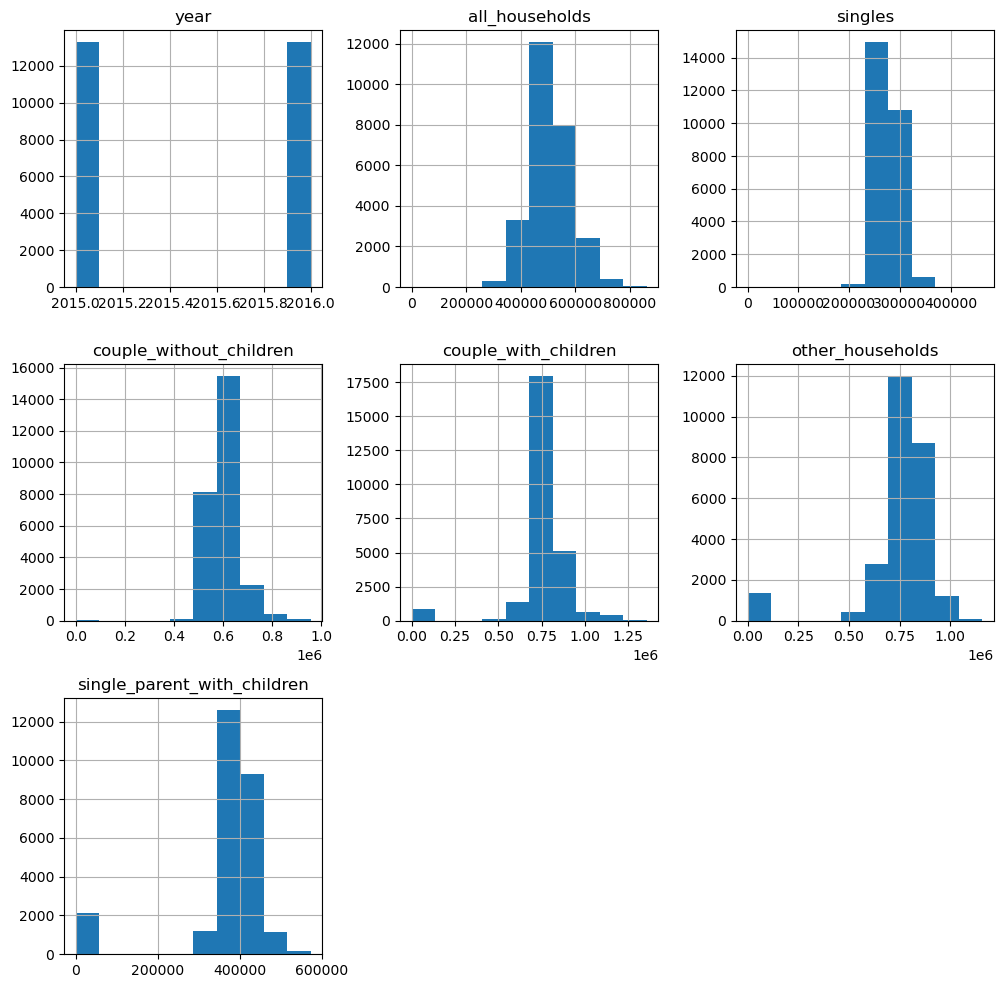

In [37]:
raw_income_dist.hist(figsize=(12,12))

### 2.2. Household distribution

In [38]:
raw_households_dist.isna().sum()

grunnkrets_id                           0
year                                    0
couple_children_0_to_5_years            0
couple_children_18_or_above             0
couple_children_6_to_17_years           0
couple_without_children                 0
single_parent_children_0_to_5_years     0
single_parent_children_18_or_above      0
single_parent_children_6_to_17_years    0
singles                                 0
dtype: int64

array([[<AxesSubplot:title={'center':'year'}>,
        <AxesSubplot:title={'center':'couple_children_0_to_5_years'}>,
        <AxesSubplot:title={'center':'couple_children_18_or_above'}>],
       [<AxesSubplot:title={'center':'couple_children_6_to_17_years'}>,
        <AxesSubplot:title={'center':'couple_without_children'}>,
        <AxesSubplot:title={'center':'single_parent_children_0_to_5_years'}>],
       [<AxesSubplot:title={'center':'single_parent_children_18_or_above'}>,
        <AxesSubplot:title={'center':'single_parent_children_6_to_17_years'}>,
        <AxesSubplot:title={'center':'singles'}>]], dtype=object)

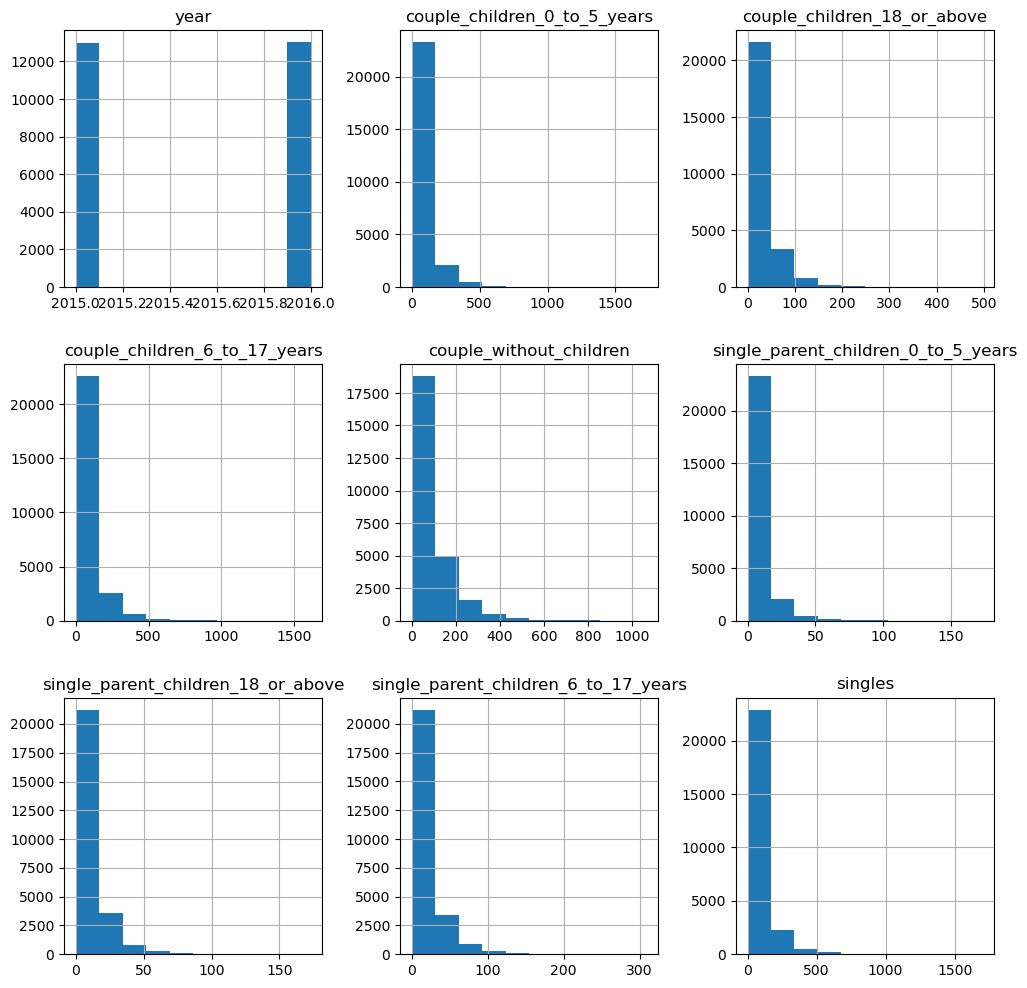

In [39]:
raw_households_dist.hist(figsize=(12,12))

### 2.3. Household Income

In [40]:
raw_income_dist.isna().sum()

grunnkrets_id                  0
year                           0
all_households                 0
singles                        0
couple_without_children        0
couple_with_children           0
other_households               0
single_parent_with_children    0
dtype: int64

array([[<AxesSubplot:title={'center':'year'}>,
        <AxesSubplot:title={'center':'all_households'}>,
        <AxesSubplot:title={'center':'singles'}>],
       [<AxesSubplot:title={'center':'couple_without_children'}>,
        <AxesSubplot:title={'center':'couple_with_children'}>,
        <AxesSubplot:title={'center':'other_households'}>],
       [<AxesSubplot:title={'center':'single_parent_with_children'}>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

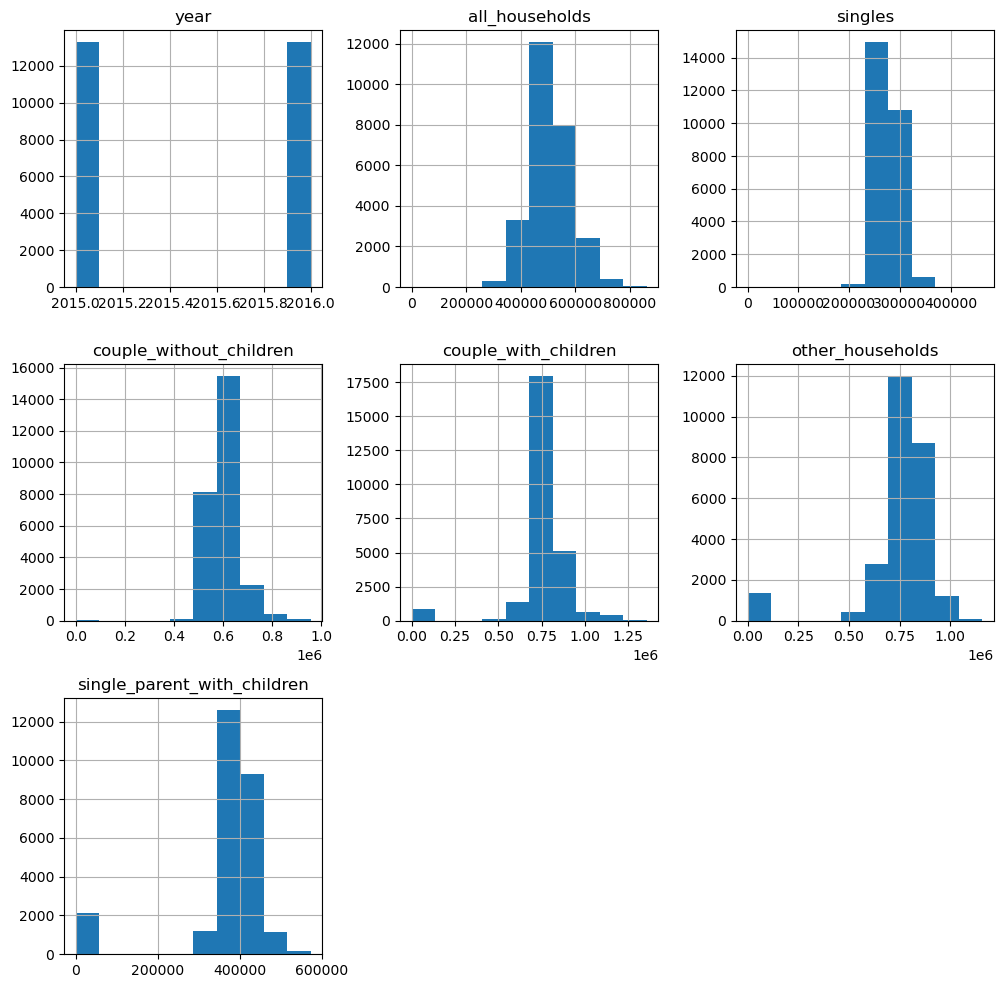

In [41]:
raw_income_dist.hist(figsize=(12,12))

### 2.4. Age Distribution

In [42]:
raw_age_dist.isna().sum()

grunnkrets_id    0
year             0
age_0            0
age_1            0
age_2            0
                ..
age_86           0
age_87           0
age_88           0
age_89           0
age_90           0
Length: 93, dtype: int64

array([[<AxesSubplot:title={'center':'year'}>,
        <AxesSubplot:title={'center':'age_0'}>,
        <AxesSubplot:title={'center':'age_1'}>,
        <AxesSubplot:title={'center':'age_2'}>,
        <AxesSubplot:title={'center':'age_3'}>,
        <AxesSubplot:title={'center':'age_4'}>,
        <AxesSubplot:title={'center':'age_5'}>,
        <AxesSubplot:title={'center':'age_6'}>,
        <AxesSubplot:title={'center':'age_7'}>,
        <AxesSubplot:title={'center':'age_8'}>],
       [<AxesSubplot:title={'center':'age_9'}>,
        <AxesSubplot:title={'center':'age_10'}>,
        <AxesSubplot:title={'center':'age_11'}>,
        <AxesSubplot:title={'center':'age_12'}>,
        <AxesSubplot:title={'center':'age_13'}>,
        <AxesSubplot:title={'center':'age_14'}>,
        <AxesSubplot:title={'center':'age_15'}>,
        <AxesSubplot:title={'center':'age_16'}>,
        <AxesSubplot:title={'center':'age_17'}>,
        <AxesSubplot:title={'center':'age_18'}>],
       [<AxesSubplot:title={'c

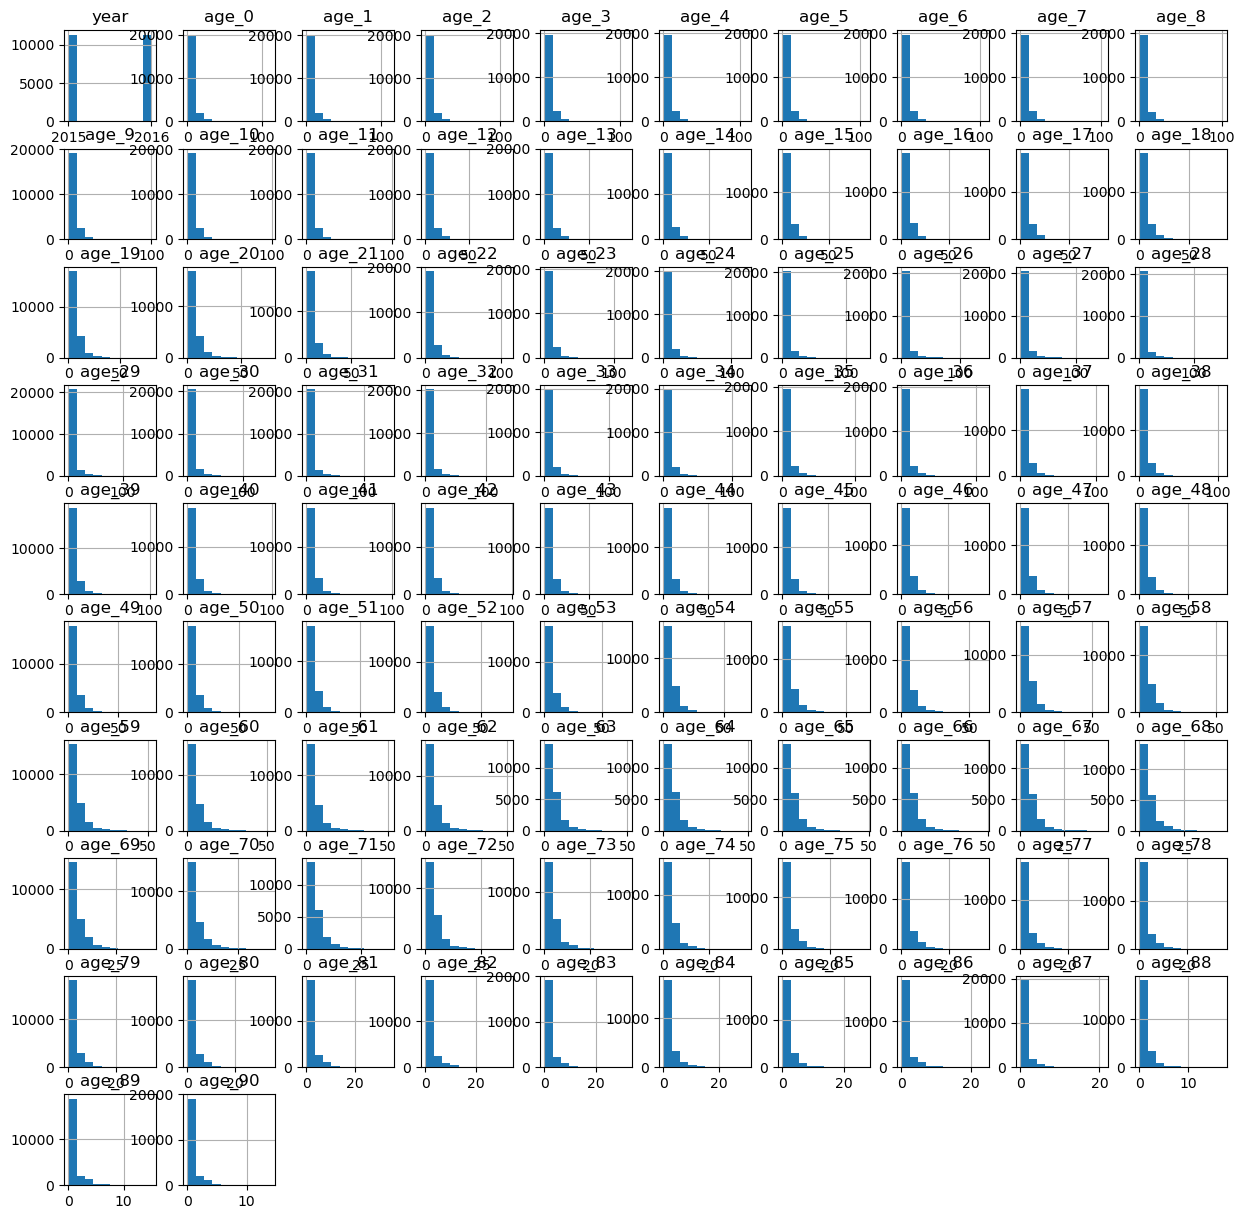

In [43]:
raw_age_dist.hist(figsize=(15,15))

#### Cleaning of grunnkrets data
We note that grunnkrets data contain both 2015 and 2016 data. As the stores dataset only contain 2016 data, per what is provided in the introduction notebook, we need to filter out only the 2016 values from the grunnkrets datasets. However, it was also discovered that the stores datasets referenced some grunnkrets_ids that were only present for 2015, but not for 2016. Thus, we need to include a subset of the grunnkrets data that exist in 2015 but not in 2016 for all the grunnkrets datasets.

Furthermore, it is also discovered that the name for district and grunnkrets is not unique across the grunnkrets dataset. Thus we have build a function **combine_keys** to combine municipality name with district to make it unique.

In [85]:
def deduplicate_year(raw_df, deduplicate_column="grunnkrets_id"):
    """
        Use 2016 values by default. If exist in 2015, merge together. Drop year.
    """
    raw_df = raw_df.copy()
    return raw_df.sort_values(by='year').drop_duplicates(subset=[deduplicate_column], keep='last').drop('year', axis=1)

In [86]:
def combine_keys(dataframe):
    dataframe = dataframe.copy()
    dataframe['t_district'] = dataframe['district_name'] + dataframe['municipality_name']
    return dataframe

In [87]:
dedup_income_dist = deduplicate_year(raw_income_dist)
dedup_age_dist = deduplicate_year(raw_age_dist)
dedup_households_dist = deduplicate_year(raw_households_dist)
dedup_grunnkrets = combine_keys(deduplicate_year(raw_grunnkrets))

### 2.5. Bus stops
The bus stop table seems to contain a significant number of entries. However, there are no keys to join the table with grunnkrets nor stores. Upon some investigation we realized that the geometry contained the latitude and longitude of the bus stop - which we can in turn utilize to enrich the stores data.

In [79]:
raw_bus_stops.isna().sum()

busstop_id              0
stopplace_type      30313
importance_level        0
side_placement       1514
geometry                0
dtype: int64

In [78]:
raw_bus_stops

,busstop_id,stopplace_type,importance_level,side_placement,geometry
0,853cb081-cc32-4880-aa3e-26e96870d874,Plattform og lomme,Mangler viktighetsnivå,LEFT_AND_RIGHT,POINT(6.54064723379766 61.0618887850553)
1,156b052b-2771-497a-b4f4-97fed59e1aca,"Lomme og skilt, ikke plattform",Mangler viktighetsnivå,LEFT_AND_RIGHT,POINT(5.89980086113255 60.1421872817075)
2,7312a280-e14f-4b09-a421-02e8fe1bc63e,NaN,Mangler viktighetsnivå,MIDDLE_LEFT,POINT(10.7781327278563 59.9299988828761)
3,d9cda2c7-355a-49c1-b56c-a33180d2a82e,NaN,Mangler viktighetsnivå,MIDDLE_LEFT,POINT(10.7781496457324 59.9301044643692)
4,f803bcd3-182d-450b-bbb4-113c6ca885c2,NaN,Mangler viktighetsnivå,MIDDLE_RIGHT,POINT(10.7781676444854 59.9302099995898)
...,...,...,...,...,...
68390,12edd887-a122-44e2-896b-a5f663917f88,"Lomme og skilt, ikke plattform",Mangler viktighetsnivå,MIDDLE,POINT(5.85431348276154 60.2029816170228)
68391,38dd0aee-b497-43c2-943b-51ab5c6d0eb7,"Lomme og skilt, ikke plattform",Mangler viktighetsnivå,MIDDLE,POINT(5.85387810987475 60.2029250857799)
68392,3803f0fe-d6dc-4211-a44d-bbc3453af289,"Lomme og skilt, ikke plattform",Mangler viktighetsnivå,MIDDLE,POINT(10.6495319726142 62.9425599428163)
68393,5b177625-d0dc-40ae-b554-e97f7d400e24,Plattform og lomme,Lokalt knutepunkt,MIDDLE,POINT(9.16421204735413 61.0634296716317)


In [80]:
def bus_stops_lat_lon(bus_stops_df):
    """
    Extract latitude and longitude as separate columns.
    """
    bus_stops_df['lng_lat'] = bus_stops_df['geometry'].str.extract(
        r'\((.*?)\)')
    bus_stops_df[['lon', 'lat']] = bus_stops_df['lng_lat'].str.split(
        " ", 1, expand=True)
    bus_stops_df[['lon', 'lat']] = bus_stops_df[[
        'lon', 'lat']].apply(pd.to_numeric)
    return bus_stops_df[['busstop_id', 'stopplace_type', 'importance_level', 'side_placement', 'geometry', 'lat', 'lon']]

In [83]:
enriched_bus_stops = bus_stops_lat_lon(raw_bus_stops)
enriched_bus_stops

/var/folders/z1/l03w8mpn5xz3mghrk0j2w5gr0000gn/T/ipykernel_3109/2155716164.py:7: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  bus_stops_df[['lon', 'lat']] = bus_stops_df['lng_lat'].str.split(


,busstop_id,stopplace_type,importance_level,side_placement,geometry,lat,lon
0,853cb081-cc32-4880-aa3e-26e96870d874,Plattform og lomme,Mangler viktighetsnivå,LEFT_AND_RIGHT,POINT(6.54064723379766 61.0618887850553),61.061889,6.540647
1,156b052b-2771-497a-b4f4-97fed59e1aca,"Lomme og skilt, ikke plattform",Mangler viktighetsnivå,LEFT_AND_RIGHT,POINT(5.89980086113255 60.1421872817075),60.142187,5.899801
2,7312a280-e14f-4b09-a421-02e8fe1bc63e,NaN,Mangler viktighetsnivå,MIDDLE_LEFT,POINT(10.7781327278563 59.9299988828761),59.929999,10.778133
3,d9cda2c7-355a-49c1-b56c-a33180d2a82e,NaN,Mangler viktighetsnivå,MIDDLE_LEFT,POINT(10.7781496457324 59.9301044643692),59.930104,10.778150
4,f803bcd3-182d-450b-bbb4-113c6ca885c2,NaN,Mangler viktighetsnivå,MIDDLE_RIGHT,POINT(10.7781676444854 59.9302099995898),59.930210,10.778168
...,...,...,...,...,...,...,...
68390,12edd887-a122-44e2-896b-a5f663917f88,"Lomme og skilt, ikke plattform",Mangler viktighetsnivå,MIDDLE,POINT(5.85431348276154 60.2029816170228),60.202982,5.854313
68391,38dd0aee-b497-43c2-943b-51ab5c6d0eb7,"Lomme og skilt, ikke plattform",Mangler viktighetsnivå,MIDDLE,POINT(5.85387810987475 60.2029250857799),60.202925,5.853878
68392,3803f0fe-d6dc-4211-a44d-bbc3453af289,"Lomme og skilt, ikke plattform",Mangler viktighetsnivå,MIDDLE,POINT(10.6495319726142 62.9425599428163),62.942560,10.649532
68393,5b177625-d0dc-40ae-b554-e97f7d400e24,Plattform og lomme,Lokalt knutepunkt,MIDDLE,POINT(9.16421204735413 61.0634296716317),61.063430,9.164212


### 2.6. Store sets
The three store sets that are made available to us for the purpose of the project - stores_train, stores_test, stores_extra - mainly contain categorical variables.

In [46]:
raw_stores_train.isna().sum()

store_id                   0
year                       0
store_name                 0
plaace_hierarchy_id        0
sales_channel_name         0
grunnkrets_id              0
address                 1774
lat                        0
lon                        0
chain_name              9122
mall_name              10579
revenue                    0
dtype: int64

#### Revenue
Revenue is the target variable of what we are to predict. As we can see below, the target variable seems to be significantly left-skewed, thus a log transformation should yield a better result prior to fitting. This is noted for future transformation and scaling jobs.

<AxesSubplot:>

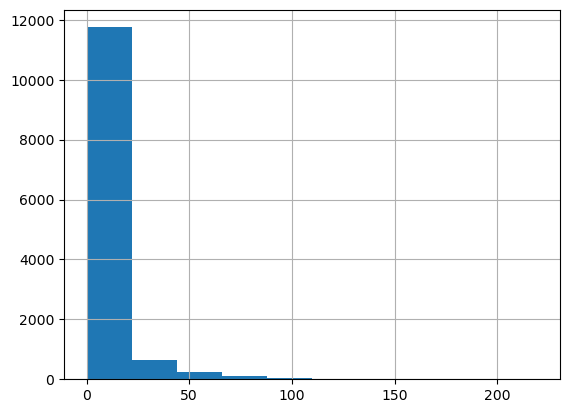

In [47]:
raw_stores_train.revenue.hist()

### Other categorical features
It is worth noting that all three sets of stores contain features with significant number of NaN values. This can potentially negatively impact the predictions. In the next section, we will present some impudation functions that aim at resolving NaNs and performing some basic feature cleaning.

In [48]:
raw_stores_test.isna().sum()

store_id                  0
year                      0
store_name                0
plaace_hierarchy_id       0
sales_channel_name        0
grunnkrets_id             0
address                1237
lat                       0
lon                       0
chain_name             6099
mall_name              7084
dtype: int64

In [49]:
raw_stores_extra.isna().sum()

store_id                   0
year                       0
store_name                 0
plaace_hierarchy_id        0
sales_channel_name         0
grunnkrets_id              0
address                 3960
lat                        0
lon                        0
chain_name             11993
mall_name              17471
dtype: int64

#### Cleaning and impudation of stores
Four major cleaning functions are provided in this section. The functions aim at filling NaN values in a more precise way than purely taking the most frequent value in the dataset. We have also utilized stores_extra for the purpose of this imputation process in order to provide a more accurate end result.

1. **impude_stores_closest_gk**: As theere are grunnkrets_id that do not reference to any records in the grunnkrets dataset, we decided to impute the relevant values with the grunnkrets_id to the closest store with an valid grunnkrets_id - one that exists in the grunnkrets datasets.

2. **impude_stores_closest_address**: As almost 25% of the stores_train data miss an address, we aim at impuding the address value with the address of the closest store - stripped of street number. We are doing that because we believe that certain streeets - e.g. Karl Johan, Bogstadveien - will be relevant in predicting the store revenue.

3. **impude_chain_name**: We also discovered by introspection that there are certain stores that are definietly a part of an existing chain, but however has chain_name equals to NaN. Thus we created a function that matches all known chain_names across the set and stores_extra to see if the store_names that contain the name of the chain and impuding them.

4. **impude_mall_name**: We expect that some mall names are missing from across the stores sets. To impude stores that are likely part of a mall, we are measuring the distance between the store to the closest store with an known mall_name. We set the threshold to be approximately 100 meters, which we think is suitable. Furthermore, even though if the store is not apart of the given mall, proximity to a mall should also yield an almost equal impact.

In [50]:
def impude_stores_closest_gk(stores_df, stores_extra_df, grunnkrets_df):
    stores_df = stores_df.copy()
    stores_extra_df = stores_extra_df.copy()
    grunnkrets_df = grunnkrets_df.copy()
    
    stores_merged_grunnkrets = stores_df.merge(grunnkrets_df, on="grunnkrets_id", how="left")
    stores_extra_merged_grunnkrets = pd.concat([stores_df, stores_extra_df], ignore_index=True).merge(grunnkrets_df, on="grunnkrets_id", how="left")
    
    invalid_gk = stores_merged_grunnkrets[stores_merged_grunnkrets['grunnkrets_name'].isna()][['store_id', 'lat', 'lon']]
    valid_gk = stores_extra_merged_grunnkrets[stores_extra_merged_grunnkrets['grunnkrets_name'].notna()][['grunnkrets_id', 'lat', 'lon']]

    mat = cdist(invalid_gk[['lat', 'lon']],
                    valid_gk[['lat', 'lon']], metric='euclidean')

    matrix_df = pd.DataFrame(mat, index=invalid_gk['store_id'], columns=valid_gk['grunnkrets_id'])
    closest_gk= matrix_df.idxmin(axis=1)

    lookup_df = pd.DataFrame(closest_gk, columns=['grunnkrets_id']).reset_index()

    for index, row in lookup_df.iterrows():
        stores_df.loc[stores_df['store_id'] == row['store_id'], 'grunnkrets_id'] = row['grunnkrets_id']
    
    return stores_df

In [51]:
impuded_stores_train = impude_stores_closest_gk(raw_stores_train, raw_stores_extra, dedup_grunnkrets)
impuded_stores_test = impude_stores_closest_gk(raw_stores_test, raw_stores_extra, dedup_grunnkrets)

In [52]:
def impude_stores_closest_address(stores_df, stores_extra_df):
    stores_df = stores_df.copy()
    stores_extra_df = stores_extra_df.copy()
    
    stores_all_df = pd.concat([stores_df, stores_extra_df], ignore_index=True)
    
    invalid_address = stores_df[stores_df['address'].isna()][['store_id', 'lat', 'lon']]
    valid_address = stores_all_df[stores_all_df['address'].notna()][['address', 'lat', 'lon']]

    mat = cdist(invalid_address[['lat', 'lon']],
                    valid_address[['lat', 'lon']], metric='euclidean')

    matrix_df = pd.DataFrame(mat, index=invalid_address['store_id'], columns=valid_address['address'])
    closest_gk= matrix_df.idxmin(axis=1)

    lookup_df = pd.DataFrame(closest_gk, columns=['address']).reset_index()

    for index, row in lookup_df.iterrows():
        stores_df.loc[stores_df['store_id'] == row['store_id'], 'address'] = row['address']
    
    return stores_df

In [53]:
_impuded_stores_train = impude_stores_closest_address(impuded_stores_train, raw_stores_extra)
_impuded_stores_test = impude_stores_closest_address(impuded_stores_test, raw_stores_extra)

In [54]:
def impude_chain_name(stores_df, stores_extra_df):
    stores_df = stores_df.copy()
    stores_extra_df = stores_extra_df.copy()
    
    unique_chain_names = sorted([str(item) for item in set(raw_stores_train['chain_name']).union(set(raw_stores_extra['chain_name']))],key=len, reverse=True)
    
    return_tuples = []
    for index, row in stores_df.iterrows():
        store_id = row['store_id']
        chain_name = row['chain_name']
        store_name = row['store_name']
        if type(chain_name) is float:
            for _chain_name in unique_chain_names:
                re_chain_name = re.sub(r'[^A-Za-z0-9 ]+', '', str(_chain_name))
                re_store_name = re.sub(r'[^A-Za-z0-9 ]+', '', store_name)
                if re_chain_name in re_store_name[:len(re_chain_name)+1] and len(store_name.split(" ")[0]) == len(_chain_name.split(" ")[0]):
                    return_tuples.append((store_id, _chain_name))
                    break
    lookup_df = pd.DataFrame(return_tuples, columns=['store_id', 'chain_name'])
    
    for index, row in lookup_df.iterrows():
        stores_df.loc[stores_df['store_id'] == row['store_id'], 'chain_name'] = row['chain_name']
    
    return stores_df

In [55]:
__impuded_stores_train = impude_chain_name(_impuded_stores_train, raw_stores_extra)
__impuded_stores_test = impude_chain_name(_impuded_stores_test, raw_stores_extra)

In [56]:
def impude_mall_name(stores_df, stores_extra_df):
    stores_df = stores_df.copy()
    stores_extra_df = stores_extra_df.copy()

    stores_all_df = pd.concat([stores_df, stores_extra_df], ignore_index=True)

    invalid_mall = stores_df[stores_df['mall_name'].isna()][['store_id', 'lat', 'lon']]
    valid_mall = stores_all_df[stores_all_df['mall_name'].notna()][['mall_name', 'lat', 'lon']]

    mat = cdist(invalid_mall[['lat', 'lon']],
                    valid_mall[['lat', 'lon']], metric='euclidean')

    matrix_df = pd.DataFrame(mat, index=invalid_mall['store_id'], columns=valid_mall['mall_name'])
    matrix_df = matrix_df[(matrix_df < 0.001)]
    closest_gk= matrix_df.idxmin(axis=1)

    lookup_df = pd.DataFrame(closest_gk, columns=['mall_name']).reset_index()
    
    for index, row in lookup_df.iterrows():
        stores_df.loc[stores_df['store_id'] == row['store_id'], 'mall_name'] = row['mall_name']
    
    return stores_df
    

In [57]:
___impuded_stores_train = impude_mall_name(__impuded_stores_train, raw_stores_extra)
___impuded_stores_test = impude_mall_name(__impuded_stores_test, raw_stores_extra)

##### Writing out impuded files
The files are written out to disk to prevent excess memory usage.

In [58]:
dedup_income_dist.to_csv("/Users/nwong/Workspace/Projects/tdt4173_project/data/impuded/grunnkrets_income_households.csv", index=False)
dedup_age_dist.to_csv("/Users/nwong/Workspace/Projects/tdt4173_project/data/impuded/grunnkrets_age_distribution.csv", index=False)
dedup_households_dist.to_csv("/Users/nwong/Workspace/Projects/tdt4173_project/data/impuded/grunnkrets_household_num_persons.csv", index=False)
dedup_grunnkrets.to_csv("/Users/nwong/Workspace/Projects/tdt4173_project/data/impuded/grunnkrets_norway_stripped.csv", index=False)
___impuded_stores_train.to_csv("/Users/nwong/Workspace/Projects/tdt4173_project/data/impuded/stores_train.csv", index=False)
___impuded_stores_test.to_csv("/Users/nwong/Workspace/Projects/tdt4173_project/data/impuded/stores_test.csv", index=False)

### Check merged dataframes
Merging stores with grunnkrets and plaace to check for referential integrity.

In [59]:
def merge_stores(stores_df, grunnkrets_df, plaace_df):
    return stores_df.merge(grunnkrets_df, on="grunnkrets_id", how="left").merge(plaace_df, on="plaace_hierarchy_id", how="left")

In [61]:
merged_stores_train = merge_stores(___impuded_stores_train, dedup_grunnkrets, raw_plaace)
merged_stores_test = merge_stores(___impuded_stores_test, dedup_grunnkrets, raw_plaace)

#### Effect of impudation preserved
As from what we can observe below, the combined impudation seems to have been able to remove a significant number of NaN values for both the training and the test set.

In [66]:
merged_stores_train.isna().sum()

store_id                   0
year                       0
store_name                 0
plaace_hierarchy_id        0
sales_channel_name_x       0
grunnkrets_id              0
address                    0
lat                        0
lon                        0
chain_name              9028
mall_name               9007
revenue                    0
grunnkrets_name            0
district_name              0
municipality_name          0
geometry                   0
area_km2                   0
sales_channel_name_y       0
lv1                        0
lv1_desc                   0
lv2                        0
lv2_desc                   0
lv3                        0
lv3_desc                   0
lv4                        0
lv4_desc                   0
dtype: int64

In [67]:
merged_stores_test.isna().sum()

store_id                   0
year                       0
store_name                 0
plaace_hierarchy_id        0
sales_channel_name_x       0
grunnkrets_id              0
address                    0
lat                        0
lon                        0
chain_name              6035
mall_name               6019
grunnkrets_name            0
district_name              0
municipality_name          0
geometry                   0
area_km2                   0
sales_channel_name_y       0
lv1                        0
lv1_desc                   0
lv2                        0
lv2_desc                   0
lv3                        0
lv3_desc                   0
lv4                        0
lv4_desc                   0
dtype: int64

## 3. Feature Engineering

### 3.1. Population
The grunnkrets age dataset only provides number of people at each age. We have built functions that uses that to calculate the total population in all geographical levels - i.e. grunnkrets, district, and municipality.

In [111]:
def population(dataset_age):
    """
        Calculate total population of grunnkrets
    """
    population = dataset_age.drop(["grunnkrets_id"], axis=1).sum(axis=1)
    dataset_age["population_count"] = population
    return dataset_age[["grunnkrets_id", "population_count"]]

def population_grouped(data_age, data_geography, grouping_element):
    """
        Calculate population of a given geographical grouping.
    """
    age_df = population(data_age)
    geography_df = data_geography
    population_df = age_df.merge(geography_df, how="left", on="grunnkrets_id")
    grouped_df = population_df.groupby([grouping_element], as_index=False)["population_count"].sum()
    return grouped_df

def population_count_grouped_by_geo_group(stores_df, age_df, grunnkrets_df, geo_groups): 
    """
        Calculate population of all geographical groupings.
    """
    combined_df = stores_df.merge(grunnkrets_df, how = "left", on = "grunnkrets_id")

    population_columns = ["population_count"]
    df_list = []

    for geo_group in geo_groups: 
        pop_df = population_grouped(age_df, grunnkrets_df, geo_group)
        merged_df = combined_df.merge(pop_df, how = "left", on = geo_group)[["store_id"] + population_columns]
        merged_df.set_index("store_id", inplace = True)
        merged_df2 = merged_df.add_prefix(f'{geo_group}_')
        df_list.append(merged_df2)

    return pd.concat(df_list, axis = 1).reset_index()

def population_density(age_df, geo_df, grouping_element):
    """
        Calculate population density based on population and area for a given geographical grouping.
    """
    age_data = population(age_df)
    geo_df = geo_df
    combined_df = age_data.merge(geo_df, how="left", on="grunnkrets_id")
    density_df = combined_df.groupby([grouping_element], as_index=False)[
        ["population_count", "area_km2"]].sum()
    density_df["density"] = density_df["population_count"] / \
        density_df["area_km2"]
    return density_df

def population_density_grouped_by_geo_group(stores_df, age_df, grunnkrets_df, geo_groups):
    """
        Calculate population density based on population and area for all geographical grouping.
    """
    grunnkrets_df_2016 = grunnkrets_df
    combined_df = stores_df.merge(grunnkrets_df_2016, how = "left", on = "grunnkrets_id")

    pop_density_columns = ["density"]
    df_list = []

    for geo_group in geo_groups: 
        pop_df = population_density(age_df, grunnkrets_df, geo_group)
        merged_df = combined_df.merge(pop_df, how = "left", on = geo_group)[["store_id"] + pop_density_columns]
        merged_df.set_index("store_id", inplace = True)
        merged_df2 = merged_df.add_prefix(f'{geo_group}_')
        df_list.append(merged_df2)

    return pd.concat(df_list, axis = 1).reset_index()

def new_pop_density(stores_df, age_dist, grunnkrets_df, geo_groups):
    population_density = population_density_grouped_by_geo_group(stores_df, age_dist, grunnkrets_df, geo_groups)
    return population_density.fillna(population_density.mean())

In [90]:
population_count_grouped_by_geo_group(raw_stores_train, dedup_age_dist, dedup_grunnkrets, ['grunnkrets_id', 't_district', 'municipality_name'])

,store_id,grunnkrets_id_population_count,t_district_population_count,municipality_name_population_count
0,983540538-974187930-44774,628.0,22775.0,401460.0
1,987074191-973117734-44755,NaN,25575.0,3993828.0
2,984890265-981157303-64491,1488.0,17135.0,176160.0
3,914057442-992924179-126912,1896.0,17130.0,292680.0
4,913018583-913063538-668469,NaN,41490.0,1119864.0
...,...,...,...,...
12854,915789943-915806929-781991,6064.0,26990.0,162858.0
12855,917921733-917982368-868081,2012.0,9045.0,178170.0
12856,911721961-911764474-496764,4468.0,35455.0,309672.0
12857,914337046-914343372-721294,1124.0,18865.0,445674.0


In [91]:
population_density_grouped_by_geo_group(raw_stores_train, dedup_age_dist, dedup_grunnkrets, ['grunnkrets_id', 't_district', 'municipality_name'])

,store_id,grunnkrets_id_density,t_district_density,municipality_name_density
0,983540538-974187930-44774,7054.865517,26303.176886,18631.035951
1,987074191-973117734-44755,NaN,97300.829802,46922.264316
2,984890265-981157303-64491,16259.527032,17159.897934,2245.512600
3,914057442-992924179-126912,34915.667049,33075.874420,8258.621603
4,913018583-913063538-668469,NaN,8720.987442,13488.478282
...,...,...,...,...
12854,915789943-915806929-781991,36425.209300,16714.836488,6877.821805
12855,917921733-917982368-868081,25665.591227,33489.330327,2331.568483
12856,911721961-911764474-496764,63347.282194,31097.629874,11877.846003
12857,914337046-914343372-721294,56430.778410,30229.509372,5363.441866


### 3.2. Age and household distributions
Same as the age distribution dataset, the distribution for age and household types are given in absolute numbers. Thus, we have made functionality to transform the two into discrete groups to understand the relative distribution of the two.

In [140]:
def age_distrubution(grunnkrets_age_df, geographic_df, grouping_element):
    """
        Age distribution both in absolute numbers and relative numbers of total (percentage) by an individual geo group.
    """
    age_df1 = grunnkrets_age_df
    age_df1["num_kids"] = age_df1.iloc[:, 1:8].sum(axis=1)
    age_df1["num_kids+"] = age_df1.iloc[:, 8:14].sum(axis=1)
    age_df1["num_youths"] = age_df1.iloc[:, 14: 19].sum(axis=1)
    age_df1["num_youthAdult"] = age_df1.iloc[:, 19:27].sum(axis=1)
    age_df1["num_adult"] = age_df1.iloc[:, 27:37].sum(axis=1)
    age_df1["num_adults+"] = age_df1.iloc[:, 37:62].sum(axis=1)
    age_df1["num_pensinors"] = age_df1.iloc[:, 62:92].sum(axis=1)

    age_df2 = age_df1[["grunnkrets_id", "num_kids", "num_kids+", "num_youths",
                       "num_youthAdult", "num_adult", "num_adults+", "num_pensinors"]]

    pop_df = population(grunnkrets_age_df)
    new_geo_df = geographic_df.drop(["geometry", "area_km2"], axis=1)
    combined_df = age_df2.merge(pop_df, how="inner", on="grunnkrets_id").merge(
        new_geo_df, how="inner", on="grunnkrets_id")
    list_columns = ["num_kids", "num_kids+", "num_youths",
                    "num_youthAdult", "num_adult", "num_adults+", "num_pensinors"]
    combined_df2 = combined_df.groupby([grouping_element], as_index=False)[
        list_columns].sum()

    pop_gk = population_grouped(
        grunnkrets_age_df, geographic_df, grouping_element)
    new_df = combined_df2.merge(pop_gk, how="inner", on=grouping_element)

    new_df["kids_%"] = new_df["num_kids"] / new_df["population_count"]
    new_df["kids+_%"] = new_df["num_kids+"] / new_df["population_count"]
    new_df["youths_%"] = new_df["num_youths"] / new_df["population_count"]
    new_df["youthAdult_%"] = new_df["num_youthAdult"] / \
        new_df["population_count"]
    new_df["adult_%"] = new_df["num_adult"] / new_df["population_count"]
    new_df["adults+_%"] = new_df["num_adults+"] / new_df["population_count"]
    new_df["pensinors_%"] = new_df["num_pensinors"] / \
        new_df["population_count"]

    age_dist_df = new_df.drop(["population_count"]+["num_kids", "num_kids+", "num_youths",
                       "num_youthAdult", "num_adult", "num_adults+", "num_pensinors"], axis=1)
    return age_dist_df

def age_dist_by_geo_group(stores_df, age_df, grunnkrets_norway_df, geo_groups): 
    """
        Age distribution both in absolute numbers and relative numbers of total (percentage) by all geo groups.
    """
    combined_df = stores_df.merge(grunnkrets_norway_df, how = "left", on = "grunnkrets_id")

    age_columns = ['kids_%', 'kids+_%', 'youths_%',
       'youthAdult_%', 'adult_%', 'adults+_%', 'pensinors_%']

    df_list = []
    for geo_group in geo_groups: 
      age_dist_df = age_distrubution(age_df, grunnkrets_norway_df, geo_group)
      merged_df = combined_df.merge(age_dist_df, how = "left", on = geo_group)[["store_id"] + age_columns]
      merged_df.set_index("store_id", inplace = True)
      merged_df2 = merged_df.add_prefix(f'{geo_group}_')
      df_list.append(merged_df2)
    
    return pd.concat(df_list, axis = 1).reset_index()

def household_type_distrubution(grunnkrets_norway_df, grunnkrets_household_pop_df, grouping_element):
    """
        Household distribution both in absolute numbers and relative numbers of total (percentage) for a specific geo group.
    """
    combined_df = grunnkrets_norway_df.merge(grunnkrets_household_pop_df, how="inner", on="grunnkrets_id")

    list_columns = ["couple_children_0_to_5_years", "couple_children_18_or_above", "couple_children_6_to_17_years",
                    "couple_without_children", "single_parent_children_0_to_5_years", "single_parent_children_18_or_above",
                    "single_parent_children_6_to_17_years", "singles"]

    grouped_df = combined_df.groupby([grouping_element], as_index=False)[
        list_columns].sum()
    grouped_df["tot_pop_count"] = grouped_df.iloc[:, 1:].sum(axis=1)

    grouped_df["%_dist_of_couple_children_0_to_5_years"] = grouped_df["couple_children_0_to_5_years"] / \
        grouped_df["tot_pop_count"]
    grouped_df["%_dist_of_couple_children_18_or_above"] = grouped_df["couple_children_18_or_above"] / \
        grouped_df["tot_pop_count"]
    grouped_df["%_dist_of_couple_children_6_to_17_years"] = grouped_df["couple_children_6_to_17_years"] / \
        grouped_df["tot_pop_count"]
    grouped_df["%_dist_of_couple_without_children"] = grouped_df["couple_without_children"] / \
        grouped_df["tot_pop_count"]
    grouped_df["%_dist_of_single_parent_children_0_to_5_years"] = grouped_df["single_parent_children_0_to_5_years"] / \
        grouped_df["tot_pop_count"]
    grouped_df["%_dist_of_single_parent_children_18_or_above"] = grouped_df["single_parent_children_18_or_above"] / \
        grouped_df["tot_pop_count"]
    grouped_df["%_dist_of_single_parent_children_6_to_17_years"] = grouped_df["single_parent_children_6_to_17_years"] / \
        grouped_df["tot_pop_count"]
    grouped_df["%_dist_of_singles"] = grouped_df["singles"] / \
        grouped_df["tot_pop_count"]

    returned_df = grouped_df.drop(["tot_pop_count"], axis=1)
    return returned_df

def household_dist_by_geo_group(stores_df, grunnkrets_household_pop_df, grunnkrets_norway_df, geo_groups):
    """
        Household distribution both in absolute numbers and relative numbers of total (percentage) for all geo group.
    """
    combined_df = stores_df.merge(grunnkrets_norway_df, how = "left", on = "grunnkrets_id")
    
    household_columns = ['couple_children_0_to_5_years', 'couple_children_18_or_above', 'couple_children_6_to_17_years', 'couple_without_children',
       'single_parent_children_0_to_5_years','single_parent_children_18_or_above','single_parent_children_6_to_17_years', 'singles',
       '%_dist_of_couple_children_0_to_5_years','%_dist_of_couple_children_18_or_above','%_dist_of_couple_children_6_to_17_years',
       '%_dist_of_couple_without_children','%_dist_of_single_parent_children_0_to_5_years','%_dist_of_single_parent_children_18_or_above',
       '%_dist_of_single_parent_children_6_to_17_years', '%_dist_of_singles']
       
    df_list = []

    for geo_group in geo_groups: 
        household_type_df = household_type_distrubution(grunnkrets_norway_df, grunnkrets_household_pop_df, geo_group)
        merged_df = combined_df.merge(household_type_df, how = "left", on = geo_group)[["store_id"] + household_columns]
        merged_df.set_index("store_id", inplace = True)
        merged_df2 = merged_df.add_prefix(f'{geo_group}_')
        df_list.append(merged_df2)
    return pd.concat(df_list, axis = 1)


def new_age_dist(stores_df, age_df, grunnkrets_df, geo_groups):
    _age_dist = age_dist_by_geo_group(stores_df, age_df, grunnkrets_df, geo_groups)
    return _age_dist.fillna(_age_dist.mean())

In [94]:
age_dist_by_geo_group(raw_stores_train, dedup_age_dist, dedup_grunnkrets, ['grunnkrets_id', 't_district', 'municipality_name'])

,store_id,grunnkrets_id_kids_%,grunnkrets_id_kids+_%,grunnkrets_id_youths_%,grunnkrets_id_youthAdult_%,grunnkrets_id_adult_%,grunnkrets_id_adults+_%,grunnkrets_id_pensinors_%,t_district_kids_%,t_district_kids+_%,...,t_district_adult_%,t_district_adults+_%,t_district_pensinors_%,municipality_name_kids_%,municipality_name_kids+_%,municipality_name_youths_%,municipality_name_youthAdult_%,municipality_name_adult_%,municipality_name_adults+_%,municipality_name_pensinors_%
0,983540538-974187930-44774,0.003430,0.005390,0.002450,0.014209,0.015679,0.024988,0.010779,0.003371,0.002725,...,0.009621,0.017460,0.017628,0.003902,0.003369,0.002745,0.004666,0.007191,0.015460,0.010286
1,987074191-973117734-44755,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.002657,0.001449,...,0.023069,0.015686,0.005693,0.004225,0.002966,0.002080,0.005134,0.010422,0.015350,0.007442
2,984890265-981157303-64491,0.005376,0.005170,0.002688,0.011993,0.017370,0.017577,0.016749,0.003759,0.003055,...,0.010127,0.016942,0.015654,0.003343,0.003095,0.002726,0.004841,0.005667,0.016088,0.011859
3,914057442-992924179-126912,0.003408,0.002597,0.000974,0.009899,0.016391,0.028075,0.015579,0.002627,0.002043,...,0.009924,0.018629,0.017359,0.003962,0.003488,0.003006,0.005522,0.006770,0.015759,0.009112
4,913018583-913063538-668469,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.005976,0.005005,...,0.007713,0.020267,0.009839,0.003981,0.003214,0.002500,0.006244,0.008242,0.014890,0.008549
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12854,915789943-915806929-781991,0.004161,0.002740,0.002385,0.006292,0.010656,0.020601,0.030089,0.003694,0.003258,...,0.007683,0.017861,0.018297,0.003612,0.003328,0.003000,0.004944,0.005618,0.015905,0.011212
12855,917921733-917982368-868081,0.003212,0.001682,0.000918,0.013917,0.017740,0.021410,0.018046,0.002374,0.001203,...,0.011901,0.014340,0.019445,0.003626,0.003236,0.002822,0.005160,0.005733,0.015648,0.011394
12856,911721961-911764474-496764,0.005509,0.002892,0.001033,0.011363,0.014944,0.020384,0.020797,0.005152,0.004032,...,0.008420,0.018640,0.013671,0.004049,0.003686,0.003154,0.004844,0.006198,0.016390,0.009298
12857,914337046-914343372-721294,0.003832,0.002190,0.000000,0.007665,0.022447,0.018615,0.022174,0.003773,0.002105,...,0.013018,0.016713,0.015778,0.004957,0.003920,0.003153,0.005070,0.007579,0.015585,0.007355


In [95]:
household_dist_by_geo_group(raw_stores_train, dedup_households_dist, dedup_grunnkrets, ['grunnkrets_id', 't_district', 'municipality_name'])

,grunnkrets_id_couple_children_0_to_5_years,grunnkrets_id_couple_children_18_or_above,grunnkrets_id_couple_children_6_to_17_years,grunnkrets_id_couple_without_children,grunnkrets_id_single_parent_children_0_to_5_years,grunnkrets_id_single_parent_children_18_or_above,grunnkrets_id_single_parent_children_6_to_17_years,grunnkrets_id_singles,grunnkrets_id_%_dist_of_couple_children_0_to_5_years,grunnkrets_id_%_dist_of_couple_children_18_or_above,...,municipality_name_single_parent_children_6_to_17_years,municipality_name_singles,municipality_name_%_dist_of_couple_children_0_to_5_years,municipality_name_%_dist_of_couple_children_18_or_above,municipality_name_%_dist_of_couple_children_6_to_17_years,municipality_name_%_dist_of_couple_without_children,municipality_name_%_dist_of_single_parent_children_0_to_5_years,municipality_name_%_dist_of_single_parent_children_18_or_above,municipality_name_%_dist_of_single_parent_children_6_to_17_years,municipality_name_%_dist_of_singles
store_id,,,,,,,,,,,,,,,,,,,,,
983540538-974187930-44774,20.0,0.0,8.0,28.0,4.0,6.0,11.0,75.0,0.131579,0.000000,...,3311.0,15127.0,0.186963,0.066607,0.195177,0.224918,0.019046,0.028364,0.050088,0.228836
987074191-973117734-44755,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.000000,0.000000,...,26785.0,191856.0,0.201397,0.050282,0.155769,0.213432,0.020295,0.023294,0.041105,0.294426
984890265-981157303-64491,45.0,9.0,38.0,84.0,13.0,6.0,12.0,150.0,0.126050,0.025210,...,1383.0,6345.0,0.159872,0.081264,0.190087,0.256692,0.014935,0.030595,0.047703,0.218853
914057442-992924179-126912,41.0,10.0,27.0,126.0,11.0,8.0,15.0,254.0,0.083333,0.020325,...,2408.0,9763.0,0.187809,0.078256,0.216275,0.230354,0.013176,0.024341,0.049420,0.200369
913018583-913063538-668469,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.000000,0.000000,...,7101.0,46364.0,0.190184,0.064961,0.189902,0.243638,0.009356,0.022811,0.037075,0.242072
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
915789943-915806929-781991,159.0,53.0,113.0,488.0,46.0,36.0,58.0,556.0,0.105368,0.035123,...,1354.0,5512.0,0.170678,0.075886,0.202808,0.252582,0.015192,0.027821,0.050293,0.204740
917921733-917982368-868081,47.0,9.0,14.0,138.0,5.0,7.0,19.0,256.0,0.094949,0.018182,...,1335.0,6368.0,0.174303,0.068219,0.199939,0.263172,0.010713,0.024154,0.044974,0.214526
911721961-911764474-496764,147.0,30.0,76.0,332.0,50.0,30.0,33.0,407.0,0.133032,0.027149,...,2507.0,9825.0,0.187748,0.078660,0.237456,0.212699,0.016971,0.027010,0.048680,0.190777


### 3.3. Median incomes
Median income is only given at the grunnkrets level. The coming functions aim at combining and aggregating income to the district and municipality level for more accurate representation.

In [96]:
def num_households(household_dist):
    household_dist = household_dist.copy()
    population = household_dist.drop(["grunnkrets_id"], axis=1).sum(axis=1)
    household_dist["household_count"] = population
    return household_dist[["grunnkrets_id", "household_count"]]

def num_households_geo(geo_group, household_dist, grunnkrets_df):
    _num_households = num_households(household_dist)
    merged_df = grunnkrets_df.merge(_num_households, on="grunnkrets_id", how="inner")
    return merged_df.groupby([geo_group], as_index=False)['household_count'].sum()

def total_grunnkrets_income(income_dist, household_dist):
    _num_households = num_households(household_dist)
    merged_df = income_dist.merge(_num_households, on="grunnkrets_id", how="inner")[['grunnkrets_id', 'household_count', 'all_households']]
    merged_df['total_income'] = merged_df['household_count'] * merged_df['all_households']
    return merged_df[['grunnkrets_id', 'total_income']]    

def total_income_geo(geo_group, income_dist, household_dist, grunnkrets_df):
    grunnkrets_income = total_grunnkrets_income(income_dist, household_dist)
    merged_df = grunnkrets_df.merge(grunnkrets_income, on="grunnkrets_id", how="inner")
    return merged_df.groupby([geo_group], as_index=False)['total_income'].sum()

def average_household_income_geo(geo_group, income_dist, household_dist, grunnkrets_df):
    income = total_income_geo(geo_group, income_dist, household_dist, grunnkrets_df)
    households = num_households_geo(geo_group, household_dist, grunnkrets_df)
    
    merged_df = income.merge(households, on=geo_group, how="inner")
    merged_df[f'avg_household_income_{geo_group}'] = merged_df['total_income'] / merged_df['household_count']
    return merged_df[[geo_group, f'avg_household_income_{geo_group}']]
    
def average_household_income_by_geo_groups(stores_df, geo_groups, income_dist, household_dist, grunnkrets_df):
    merged_df = stores_df.merge(grunnkrets_df, how="left", on="grunnkrets_id")
    
    df_list = []
    for geo_group in geo_groups:
        df = average_household_income_geo(geo_group, income_dist, household_dist, grunnkrets_df)
        df_list.append(merged_df.merge(df, how="left", on=[geo_group])[['store_id', f'avg_household_income_{geo_group}']])
    
    dfs = [df.set_index('store_id') for df in df_list]
    return pd.concat(dfs, axis=1).reset_index()

In [97]:
average_household_income_by_geo_groups(raw_stores_train, ['grunnkrets_id', 't_district', 'municipality_name'], dedup_income_dist, dedup_households_dist, dedup_grunnkrets)

,store_id,avg_household_income_grunnkrets_id,avg_household_income_t_district,avg_household_income_municipality_name
0,983540538-974187930-44774,398700.0,398700.0,482029.967929
1,987074191-973117734-44755,374800.0,374800.0,475189.553686
2,984890265-981157303-64491,347900.0,347900.0,472693.232616
3,914057442-992924179-126912,394000.0,394000.0,540647.152386
4,913018583-913063538-668469,623700.0,623700.0,513144.080301
...,...,...,...,...
12854,915789943-915806929-781991,381900.0,381900.0,488556.095387
12855,917921733-917982368-868081,292000.0,292000.0,482236.238378
12856,911721961-911764474-496764,440200.0,440200.0,542489.751456
12857,914337046-914343372-721294,382400.0,382400.0,580088.361361


### 3.4. Stores distance functions
One hypothesis we had was that the concentration of stores may have an impact on the overall revenue to stores - both in aggregate but also across store types. Thus we have created two main functions to aggregate the number of stores of the same type - and irrespective of types - within an radius to any given store. Furthermore, we have also developed a related functionality that measures the cartesian distance between any given store and the closest store of the same type across all levels.

In [112]:
def stores_in_radius(stores_df, compare_df, radius=0.1, store_type_group=None):
    """
        Count the number of stores within a given radius
    """
    mat = cdist(stores_df[['lat', 'lon']],
                compare_df[['lat', 'lon']], metric="euclidean")
    
    new_df = pd.DataFrame(
        mat, index=stores_df['store_id'], columns=compare_df['store_id']
    )
    
    if store_type_group is None:
        count = new_df[(new_df < radius) & (new_df > 0)].count(axis=1)
        return count.to_frame(name="all_stores_in_radius").reset_index()
    
    else:
        test_df = new_df[(new_df < radius) & (new_df > 0)]
        store_count = {}
        
        for index, row in test_df.iterrows():
            nearby_stores = row.dropna().index.values
            index_type = compare_df.loc[compare_df['store_id'] == index, store_type_group].iat[0]
            
            number_same = compare_df[(compare_df['store_id'].isin(nearby_stores)) & (compare_df[store_type_group] == index_type)]['store_id'].count()
            
            store_count[index] = number_same
        
        df = pd.DataFrame.from_dict(store_count, orient='index', columns=[f"{store_type_group}_in_radius"])
        df.index.rename('store_id', inplace=True)
        return df.reset_index()
    
def stores_in_radius_new(stores_merged, compare_df, radius=0.05):
    lv_1 = stores_in_radius(stores_merged, compare_df, radius=radius, store_type_group='lv1_desc')
    lv_2 = stores_in_radius(stores_merged, compare_df, radius=radius, store_type_group='lv2_desc')
    lv_3 = stores_in_radius(stores_merged, compare_df, radius=radius, store_type_group='lv3_desc')
    lv_4 = stores_in_radius(stores_merged, compare_df, radius=radius, store_type_group='lv4_desc')
    all_count = stores_in_radius(stores_merged, compare_df, radius=radius, store_type_group=None)
    
    return lv_1.merge(lv_2, on="store_id", how="inner").merge(lv_3, on="store_id", how="inner").merge(lv_4, on="store_id", how="inner").merge(all_count, on="store_id", how="inner")

def store_closest(stores_df, compare_df, store_type_group="lv4_desc"):
    """
    Id and distance of the closest store of same type in the same group.
    """
    
    store_types_in_group = stores_df[store_type_group].unique()
    df_list = []
    for store_type in store_types_in_group:
        stores_by_type = stores_df[stores_df[store_type_group] == store_type]
        stores_comp_by_type = compare_df[compare_df[store_type_group] == store_type]
        
        mat = cdist(stores_by_type[['lat', 'lon']], stores_comp_by_type[['lat', 'lon']], metric='euclidean')
        
        df = pd.DataFrame(
            mat, index=stores_by_type['store_id'], columns=stores_comp_by_type['store_id'])
        
        df = df[df > 0]
        
        stores = df.index
        closest = df.idxmin(axis=1)
        distance = df.min(axis=1)
        
        new_df = pd.DataFrame({'store_id': stores.values, 'closest_store': closest.values, 'distance': distance.values})
        df_list.append(new_df)
        
    
    return pd.concat(df_list, ignore_index=True)


def store_closest_by_store_groups(stores_df, compare_df, store_type_groups):
    """
        Closest store across all store levels.
    """
    df_list = []
    
    for store_type_group in store_type_groups:
        df = store_closest(stores_df, compare_df, store_type_group=store_type_group)
        df.rename(columns={'distance': f'distance_to_{store_type_group}'}, inplace=True)
        df_list.append(df[['store_id', f'distance_to_{store_type_group}']])

    dfs = [df.set_index('store_id') for df in df_list]
    return pd.concat(dfs, axis=1).reset_index()

def distance_to_closest_group(stores_df, compare_df, group):
    """
        Mall or chain
    """
    mat = cdist(
        stores_df[['lat', 'lon']],
        compare_df[compare_df[group].notna()][['lat', 'lon']], metric="euclidean"
    )
    
    new_df = pd.DataFrame(
        mat, index=stores_df['store_id'], columns=compare_df[compare_df[group].notna()]['store_id']
    )
    
    new_df = new_df[new_df > 0]
    
    stores = new_df.index
    # closest = new_df.idxmin(axis=1)
    distance = new_df.min(axis=1)
    
    return pd.DataFrame({'store_id': stores.values, f'distance_closest_{group}': distance.values})

In [110]:
stores_in_radius_new(merged_stores_train, pd.concat([merged_stores_train, raw_stores_extra.merge(raw_plaace, on="plaace_hierarchy_id", how="left")]))

,store_id,lv1_desc_in_radius,lv2_desc_in_radius,lv3_desc_in_radius,lv4_desc_in_radius,all_stores_in_radius
0,983540538-974187930-44774,120,85,1,1,587
1,987074191-973117734-44755,1362,980,19,19,3830
2,984890265-981157303-64491,43,33,0,0,169
3,914057442-992924179-126912,90,66,1,1,388
4,913018583-913063538-668469,56,43,1,1,316
...,...,...,...,...,...,...
12854,915789943-915806929-781991,111,24,2,1,189
12855,917921733-917982368-868081,160,20,1,0,239
12856,911721961-911764474-496764,381,62,2,0,621
12857,914337046-914343372-721294,424,64,2,0,666


In [105]:
store_closest_by_store_groups(merged_stores_train, pd.concat([merged_stores_train, raw_stores_extra.merge(raw_plaace, on="plaace_hierarchy_id", how="left")]), ['lv1_desc', 'lv2_desc', 'lv3_desc', 'lv4_desc'])

,store_id,distance_to_lv1_desc,distance_to_lv2_desc,distance_to_lv3_desc,distance_to_lv4_desc
0,983540538-974187930-44774,6.266641e-04,0.000627,0.046960,0.046960
1,987074191-973117734-44755,3.596392e-07,0.000315,0.001865,0.001865
2,984890265-981157303-64491,8.339069e-04,0.000834,0.357146,0.357146
3,914057442-992924179-126912,3.480443e-04,0.000348,0.043278,0.043278
4,913018583-913063538-668469,3.908446e-07,0.001208,0.002809,0.002809
...,...,...,...,...,...
12854,913913973-913919653-703808,5.323396e-03,0.005323,0.005323,0.005323
12855,971230584-974872617-42523,1.161426e-02,0.067161,0.067161,0.067161
12856,979617615-979639317-58196,9.500240e-03,0.013467,0.013467,0.013467
12857,991015361-991077588-321523,5.392853e-04,0.000539,0.000539,0.000539


In [116]:
distance_to_closest_group(raw_stores_test, pd.concat([raw_stores_train, raw_stores_extra]), 'mall_name')

,store_id,distance_closest_mall_name
0,914206820-914239427-717245,0.010747
1,916789157-916823770-824309,0.011561
2,913341082-977479363-2948,0.000009
3,889682582-889697172-28720,0.014268
4,997991699-998006945-417222,0.008051
...,...,...
8572,917323003-917383529-844309,0.030662
8573,917353379-917411824-845904,0.007229
8574,917072302-917089248-833647,0.000774
8575,916960557-916993161-829908,0.006711


In [117]:
distance_to_closest_group(raw_stores_test, pd.concat([raw_stores_train, raw_stores_extra]), 'chain_name')

,store_id,distance_closest_chain_name
0,914206820-914239427-717245,3.698460e-04
1,916789157-916823770-824309,3.620852e-07
2,913341082-977479363-2948,8.751072e-06
3,889682582-889697172-28720,1.989786e-03
4,997991699-998006945-417222,3.638586e-03
...,...,...
8572,917323003-917383529-844309,2.318987e-02
8573,917353379-917411824-845904,3.670178e-03
8574,917072302-917089248-833647,6.246196e-04
8575,916960557-916993161-829908,6.711264e-03


### 3.5 Bus Stops features

In [132]:
def bus_stops_closest(stores_df, bus_stops_df, importance_level="Regionalt knutepunkt"):
    """
    Id and distance of the closest bus stop to all stores.
    """
    bus_stops_df = bus_stops_df[bus_stops_df['importance_level'] == importance_level]
    mat = cdist(stores_df[['lat', 'lon']],
                bus_stops_df[['lat', 'lon']], metric='euclidean')

    new_df = pd.DataFrame(
        mat, index=stores_df['store_id'], columns=bus_stops_df['busstop_id'])

    stores = stores_df.store_id
    closest = new_df.idxmin(axis=1)
    distance = new_df.min(axis=1)

    return pd.DataFrame({'store_id': stores.values, 'closest_bus_stop': closest.values, 'distance': distance.values})

def bus_stops_in_radius(stores_df, bus_stops_df, radius=0.1, importance_level=None):
    """
    Number of bus stops within a given radius. The importance level of bus stops can be specified.
    """
    if importance_level is not None:
        bus_stops_df = bus_stops_df[bus_stops_df['importance_level'] == importance_level]

    mat = cdist(stores_df[['lat', 'lon']],
                bus_stops_df[['lat', 'lon']], metric='euclidean')
    new_df = pd.DataFrame(
        mat, index=stores_df['store_id'], columns=bus_stops_df['busstop_id'])
    count = pd.DataFrame(new_df[new_df < radius].count(axis=1)).reset_index()
    count.rename(columns={0: 'count'}, inplace=True)
    return count

# Relevant feature engineering functions.
def bus_stops_distance_by_importance(stores_df, bus_stops_df, stop_importance_levels):
    """
    Distance for each store to the closest bus stop of each importance_level
    """
    df_list = []
    for importance_level in stop_importance_levels:
        importance_level_cleaned = importance_level.lower().replace(" ", "_")
        df = bus_stops_closest(stores_df, bus_stops_df, importance_level=importance_level)
        df.rename(columns={'distance': f'distance_to_{importance_level_cleaned}'}, inplace=True)
        df_list.append(df[['store_id', f'distance_to_{importance_level_cleaned}']])

    dfs = [df.set_index('store_id') for df in df_list]
    return pd.concat(dfs, axis=1)

def bus_stops_in_radius_by_importance(stores_df, bus_stops_df, stop_importance_levels, radius=0.01):
    """
    Number of bus stops in radius of store for each importance level.
    """
    df_list = []
    df_list.append(bus_stops_in_radius(stores_df, bus_stops_df, radius=radius).rename(columns={'count':'number_of_all_stop_types'})) # All bus stops in radius
    
    for importance_level in stop_importance_levels:
        importance_level_cleaned = importance_level.lower().replace(" ", "_")
        df = bus_stops_in_radius(stores_df, bus_stops_df, importance_level=importance_level, radius=radius)
        df.rename(columns={'count': f'number_of_{importance_level_cleaned}'}, inplace=True)
        df_list.append(df[['store_id', f'number_of_{importance_level_cleaned}']])

    dfs = [df.set_index('store_id') for df in df_list]
    return pd.concat(dfs, axis=1)

stop_importance_levels = ['Mangler viktighetsnivå',
                          'Standard holdeplass',
                          'Lokalt knutepunkt',
                          'Nasjonalt knutepunkt',
                          'Regionalt knutepunkt',
                          'Annen viktig holdeplass']

In [133]:
bus_stops_distance_by_importance(___impuded_stores_train, enriched_bus_stops, stop_importance_levels)

,distance_to_mangler_viktighetsnivå,distance_to_standard_holdeplass,distance_to_lokalt_knutepunkt,distance_to_nasjonalt_knutepunkt,distance_to_regionalt_knutepunkt,distance_to_annen_viktig_holdeplass
store_id,,,,,,
983540538-974187930-44774,0.005315,0.012600,0.005467,0.294614,0.016952,0.155313
987074191-973117734-44755,0.001579,0.045599,0.001257,0.020375,0.001559,0.116319
984890265-981157303-64491,0.000371,0.011161,0.025783,0.326362,0.017330,0.054763
914057442-992924179-126912,0.005329,0.010858,0.016854,0.012352,0.000522,5.257526
913018583-913063538-668469,0.003096,0.002093,0.003370,0.319223,0.644539,0.006737
...,...,...,...,...,...,...
915789943-915806929-781991,0.001349,0.008576,0.006203,0.176835,0.005978,0.009062
917921733-917982368-868081,0.002951,0.118968,0.022918,0.333546,0.051408,0.168095
911721961-911764474-496764,0.001587,0.102015,0.025107,0.249433,0.032679,0.037453


In [135]:
bus_stops_in_radius_by_importance(___impuded_stores_train, enriched_bus_stops, stop_importance_levels)

,number_of_all_stop_types,number_of_mangler_viktighetsnivå,number_of_standard_holdeplass,number_of_lokalt_knutepunkt,number_of_nasjonalt_knutepunkt,number_of_regionalt_knutepunkt,number_of_annen_viktig_holdeplass
store_id,,,,,,,
983540538-974187930-44774,10,9,0,1,0,0,0
987074191-973117734-44755,32,20,0,11,0,1,0
984890265-981157303-64491,14,14,0,0,0,0,0
914057442-992924179-126912,11,5,0,0,0,6,0
913018583-913063538-668469,33,10,19,2,0,0,2
...,...,...,...,...,...,...,...
915789943-915806929-781991,33,22,5,1,0,4,1
917921733-917982368-868081,19,19,0,0,0,0,0
911721961-911764474-496764,14,14,0,0,0,0,0


## 4. Further Data Exploration
Now that we have our initial set of features ready, we aim at combining them into the respective stores datasets to check for correlation and to select the most relevant features that we are going to use for prediction.

### 4.1. Revenue clusters
One interesting metric we want to check for is where the cluster centers are for stores - weighted by the revenue levels. This is to ensure that the dataset is geographically spread out, and representative. From what can be seen below, the cluster centers - given 100 clusters - seems to be fairly geographically distributed - with concentration around major cities and regions. Thus it seems like that the dataset should be representative in terms of geography.

In [136]:

kmeans_ = KMeans(100, random_state=1)
kmeans_.fit_transform(raw_stores_train[['lat', 'lon']], sample_weight=raw_stores_train['revenue'])

cluster_centers_df = pd.DataFrame(kmeans_.cluster_centers_)

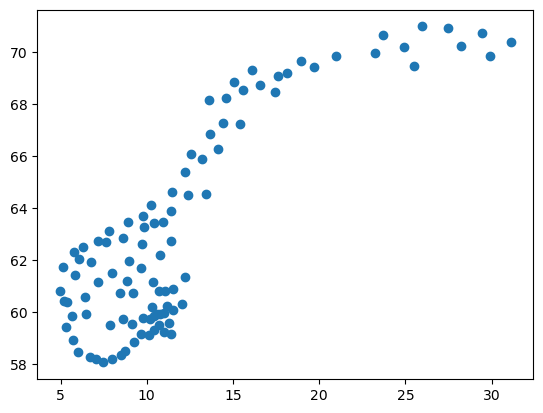

In [137]:
plt.scatter(cluster_centers_df[1], cluster_centers_df[0])

### 4.2. Merging with new features to measure correlation

In [138]:
stores_train_merged = ___impuded_stores_train.merge(raw_plaace, on="plaace_hierarchy_id", how="left")
stores_extra_merged = raw_stores_extra.merge(raw_plaace, on="plaace_hierarchy_id", how="left")
compare_train_df = pd.concat([stores_train_merged, stores_extra_merged], ignore_index=True)

stop_importance_levels = ['Mangler viktighetsnivå',
                          'Standard holdeplass',
                          'Lokalt knutepunkt',
                          'Nasjonalt knutepunkt',
                          'Regionalt knutepunkt',
                          'Annen viktig holdeplass']
store_types = ['lv1_desc', 'lv2_desc', 'lv3_desc', 'lv4_desc']
geo_groups = ['grunnkrets_id','t_district','municipality_name']

In [141]:
merged_stores_train = stores_train_merged \
    .merge(dedup_grunnkrets, on="grunnkrets_id", how="left") \
    .merge(dedup_income_dist, on="grunnkrets_id", how="left") \
    .merge(store_closest_by_store_groups(stores_train_merged, compare_train_df, store_types), on="store_id", how="left") \
    .merge(stores_in_radius_new(stores_train_merged, compare_train_df), on="store_id", how="left") \
    .merge(new_pop_density(___impuded_stores_train, dedup_age_dist, dedup_grunnkrets, geo_groups), on="store_id", how="left") \
    .merge(average_household_income_by_geo_groups(___impuded_stores_train, geo_groups, dedup_income_dist, dedup_households_dist, dedup_grunnkrets)) \
    .merge(bus_stops_distance_by_importance(___impuded_stores_train, enriched_bus_stops, stop_importance_levels).reset_index(level=0), on="store_id", how="left") \
    .merge(new_age_dist(___impuded_stores_train, dedup_age_dist, dedup_grunnkrets, geo_groups), on="store_id", how="left") \
    .merge(distance_to_closest_group(stores_train_merged, compare_train_df, "mall_name"), on="store_id", how="left") \
    .merge(distance_to_closest_group(stores_train_merged, compare_train_df, "chain_name"), on="store_id", how="left") 

/var/folders/z1/l03w8mpn5xz3mghrk0j2w5gr0000gn/T/ipykernel_3109/3093854889.py:71: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  return population_density.fillna(population_density.mean())
/var/folders/z1/l03w8mpn5xz3mghrk0j2w5gr0000gn/T/ipykernel_3109/2392706791.py:122: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  return _age_dist.fillna(_age_dist.mean())


In [150]:
pd.DataFrame(merged_stores_train.corr()['revenue']).sort_values('revenue')

/var/folders/z1/l03w8mpn5xz3mghrk0j2w5gr0000gn/T/ipykernel_3109/3089802451.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  pd.DataFrame(merged_stores_train.corr()['revenue']).sort_values('revenue')


,revenue
distance_to_lv1_desc,-0.051313
t_district_pensinors_%,-0.048151
distance_to_lv4_desc,-0.041686
distance_to_lv2_desc,-0.041569
distance_to_lv3_desc,-0.039167
municipality_name_pensinors_%,-0.033016
distance_closest_mall_name,-0.027798
distance_closest_chain_name,-0.023608
grunnkrets_id_pensinors_%,-0.022757
distance_to_standard_holdeplass,-0.022595


/var/folders/z1/l03w8mpn5xz3mghrk0j2w5gr0000gn/T/ipykernel_3109/3016862174.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(merged_stores_train.corr())


<AxesSubplot:>

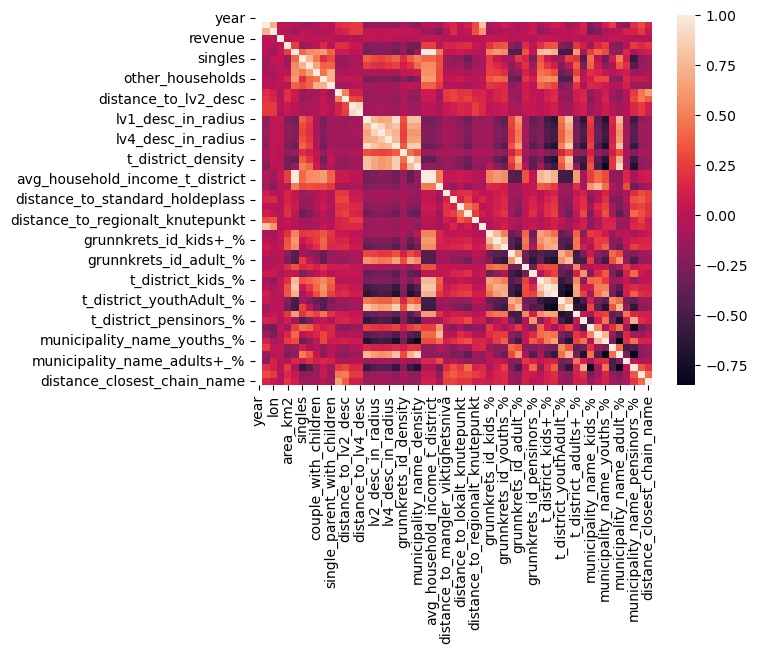

In [146]:
sns.heatmap(merged_stores_train.corr())

## 4. Model Selection and Fitting

## 5. Model Interpretation

For our model we used H2O AutoML. We knew that ensamble learning would be important, and we had known about AUTOML models that could do ensamble modeling for us. We would just give it the training set and select how many models to use, and which models to exclude and it would find a collection of models for us. Using H2o we saved a lot of time figuring out which models were best for us, and it had other practical features as well. 

H2O would for instance 1-hot-encode categorical values for us. This meant that we could pass string values to the model and it would automatically encode the values for us. Doing this meant that we did not have to spend as much time manually encoding different values. The most relevant for us was that we simply gave it numerical values and categorical values. 

One negative aspect of H2O is that it does not automatically select features. As we understand it, it will use whatever feautes we give it. It does not matter if they are negative or postive to the value. Therefore we had to be quite selective about which features we gave to the model, and we often noticed that adding a feature would have a negative impact on the predictions. It might be that some of the features we have in the submitted models actually hurt our predicitons, and we have just not been able to notice them. If we were to work on this project for a longer time it would have been relevant to remove features systematiclally to see if the model increased its prediction. We simply did not have the time to do this more towards the end. 

Some of the features we selected were based on wording. The last name count and first name counts were based on a assumption that the stores that had parts of the names that were more common to be higher in reveneue. Take for instance REMA 1000 or "treningsenter", these were often in the store name column and often had larger revenue. We also thought that if a store had the word "AS" in it that that would be associated with a revenue. Therefore we had the column "AS" in it. By counting how often the last word and first word in the store name appeared we had a measure of how poplar a naming would be.

Further more we used distance features, we had euclidian distance features to stores of the same type, and chains, and also used income features we got from the iformation set. 


We found that the features with most impact were chain name, mall name and sales channel name. This makes sense, as a store in a chain often would have similar income to another store in a chain. The same goes for sales channel, as we think a store within the same industry could have the same revenue. This applies to mall name as well. 

All of the numerical features were transformed, so that they would be more gaussian. We discovered that the features were often heavily skewed to the left, and by transforming the values we got better performance from the features.